In [8]:
import numpy as np
import pandas as pd

# !pip install yfinance
import yfinance as yf

# !pip3 install neo4j-driver
from neo4j import GraphDatabase, basic_auth

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(42)

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Download Data from Stocks Sectors ETFs

In [2]:
# List of Tickers Symbols
instrumentIds = ['XLK','XLV','XLF','XLE','XLB','XLY',
                 'XLI','XLU','XLP','XLC']

In [3]:
# Multiple Tickers Data
TickersData = yf.download(
        # tickers list or string as well
        tickers = instrumentIds,
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "1y",
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = False,
        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,
        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,
        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data = TickersData['Close']
print(len(data))
data.tail()

[*********************100%***********************]  10 of 10 completed
253


,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,
2022-09-07,76.169998,54.240002,78.300003,33.459999,93.790001,134.080002,73.449997,77.129997,127.150002,159.929993
2022-09-08,76.910004,54.110001,78.639999,34.049999,94.070000,134.539993,73.260002,77.070000,129.360001,161.419998
2022-09-09,78.070000,55.619999,80.599998,34.360001,95.290001,137.199997,73.980003,77.379997,130.500000,164.479996
2022-09-12,78.800003,55.910000,82.080002,34.639999,95.860001,139.399994,74.269997,78.120003,131.369995,166.600006
2022-09-13,77.099998,53.660000,80.720001,33.762501,93.709999,133.949997,72.889999,77.180000,128.330002,160.309998


Let's check the Pearson Correlations.

<AxesSubplot:>

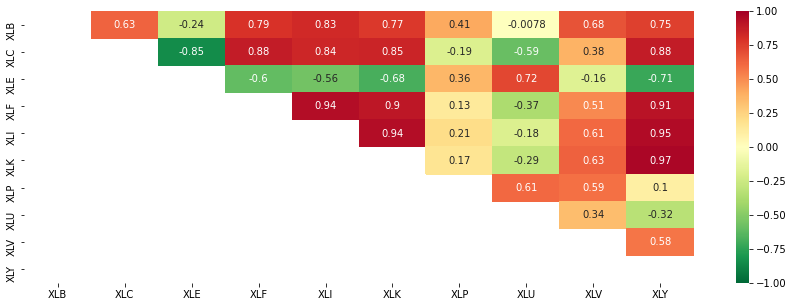

In [4]:
lower = np.tril(data.corr())
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(data.corr(), vmin =-1, vmax =+1, annot=True, cmap='RdYlGn_r',mask=lower)

In [5]:
# Create a Stacked and Normalized (0-100) Correlation Matrix
corr_matrix = data.corr().replace(1,np.nan).stack(dropna=True)
corr_matrix = (corr_matrix*-50)+50
corr_matrix = corr_matrix.to_frame(name='Distance').reset_index()
corr_matrix = corr_matrix.rename( columns={'level_0': 'Origin', 'level_1': 'Destination'} )
corr_matrix.head()

,Origin,Destination,Distance
0,XLB,XLC,18.397803
1,XLB,XLE,61.770059
2,XLB,XLF,10.520749
3,XLB,XLI,8.659430
4,XLB,XLK,11.621884


In [6]:
# Export Correlation Matrix to CSV File
corr_matrix.to_csv('CorrelationMatrix.csv')
# Copy Correlation Matrix to Neo4j import directory
!cp CorrelationMatrix.csv "..\.Neo4jDesktop\relate-data\dbmss\dbms-ec440f6d-a3ad-4945-b5cd-38d84ef859d6\import"

## Neo4j Driver

In [17]:
# Connect to neo4j

uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=basic_auth("neo4j", "admin"))
driver.verify_connectivity()

<ipython-input-17-6abb0f750323>:5: ExperimentalWarning: The configuration may change in the future.
  driver.verify_connectivity()


'Neo4j/4.4.5'

In [18]:
# Delete Previous Graph

delete_graph = ''' 
MATCH (n)
DETACH DELETE n
'''

with driver.session(database="neo4j") as session:
   session.run(delete_graph)

In [19]:
# Load Correlation Matrix CSV File

load_correlation = ''' 
LOAD CSV WITH HEADERS FROM 'file:///CorrelationMatrix.csv' AS row
MERGE (o:Ticker {name: row.Origin})
MERGE (d:Ticker {name: row.Destination})
MERGE (o)-[c:CORR {distance: toFloat(row.Distance)}]->(d)
'''

with driver.session(database="neo4j")as session:
   session.run(load_correlation)

In [20]:
# Delete Projected Graph

delete_graph = '''
CALL gds.graph.drop('StockSectors')
'''

with driver.session(database="neo4j") as session:
   session.run(delete_graph)

In [21]:
# Create a new Graph Projection
project_graph = ''' 
CALL gds.graph.project(
  'StockSectors',
  'Ticker',
  {
    CORR: {
      properties: 'distance'
    }
  }
)
'''

with driver.session(database="neo4j") as session:
   session.run(project_graph)

In [22]:
# Run the Minimum Weight Spanning Tree algorithm and write back results to the graph
mst_query = ''' 
MATCH (n:Ticker {name: 'XLE'})
CALL gds.alpha.spanningTree.minimum.write('StockSectors', {
  startNodeId: id(n),
  relationshipWeightProperty: 'distance',
  writeProperty: 'MINST',
  weightWriteProperty: 'writeCost'
})
YIELD preProcessingMillis, computeMillis, writeMillis, effectiveNodeCount
RETURN preProcessingMillis, computeMillis, writeMillis, effectiveNodeCount;
'''

with driver.session(database="neo4j") as session:
   session.run(mst_query)

In [31]:
# Query and Print results
cypher_query = '''
MATCH path = (n:Ticker {name: 'XLE'})-[:MINST*]-()
WITH relationships(path) AS rels
UNWIND rels AS rel
WITH DISTINCT rel AS rel
RETURN startNode(rel).name AS origin, endNode(rel).name AS destination, rel.writeCost AS distance
'''

with driver.session(database="neo4j") as session:
  results = session.read_transaction(
    lambda tx: tx.run(cypher_query,
                      limit=500).data())
  print('Minimum Spanning Tree - Western Cities - Canada\n')
  for record in results:
    print(record['origin'],'and', record['destination'],'has a correlation of', round((record['distance']-50)/-50,2))

driver.close()

Minimum Spanning Tree - Western Cities - Canada

XLE and XLU has a correlation of 0.72
XLU and XLP has a correlation of 0.61
XLP and XLV has a correlation of 0.59
XLV and XLB has a correlation of 0.68
XLB and XLI has a correlation of 0.83
XLI and XLY has a correlation of 0.95
XLY and XLK has a correlation of 0.97
XLY and XLC has a correlation of 0.88
XLI and XLF has a correlation of 0.94


## Cointegration
Cointegration, is a "different" form of correlation. If two series are cointegrated, the ratio between them will vary around a mean.
For pairs trading to work between two timeseries, the expected value of the ratio over time must converge to the mean, i.e. they should be cointegrated.

### Testing for Cointegration
There is a convenient test that lives in statsmodels.tsa.stattools. We should see a very low p-value, as we've artificially created two series that are as cointegrated as physically possible.

In [5]:
# compute the p-value of the cointegration test
# will inform us as to whether the ratio between the 2 timeseries is stationary
# around its mean
# score, pvalue, _ = coint(X,Y)


### How to make a pairs trade?
Because two cointegrated time series drift towards and apart from each other, there will be times when the spread is high and times when the spread is low. We make a pairs trade by buying one security and selling another. This way, if both securities go down together or go up together, we neither make nor lose money — we are market neutral.

### Using Data to find securities that behave like this
The best way to do this is to start with securities you suspect may be cointegrated and perform a statistical test. If you just run statistical tests over all pairs, you’ll fall prey to multiple comparison bias.


In [6]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

Lets  run our method on the list and see if any pairs are cointegrated.

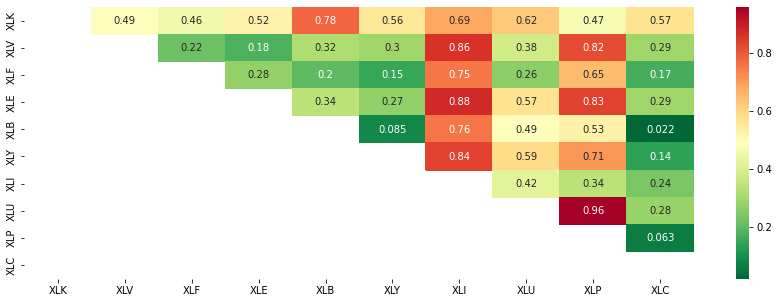

Cointegrated Pairs: [('XLI', 'XLY')]


In [7]:
# Heatmap to show the p-values of the cointegration test between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
m = [0,0.2,0.4,0.6,0.8,1]
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(pvalues, xticklabels=instrumentIds, yticklabels=instrumentIds,annot=True, cmap='RdYlGn_r', mask=(pvalues>=0.98))
plt.show()
print('Cointegrated Pairs:', pairs)

Looks like Industrials (XLI) and Consumer discretionary (XLY) are cointegrated. Let's take a look at the prices to make sure there's nothing weird going on

0.021732518163774275


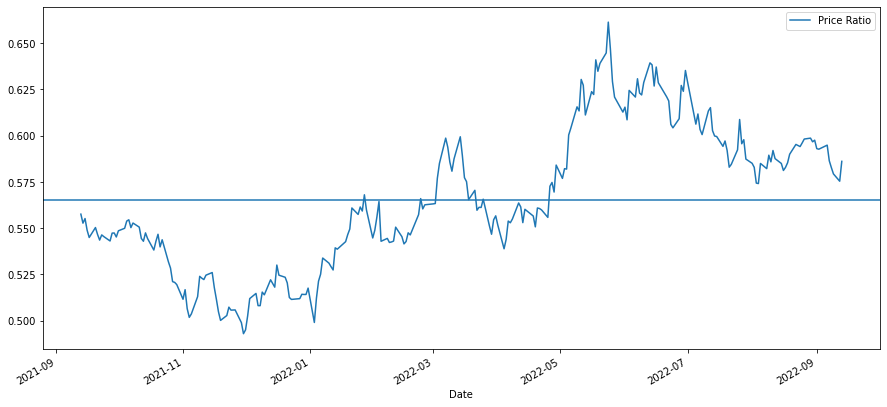

In [8]:
S1 = data['XLI']
S2 = data['XLY']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

The ratio does look like it moved around a stable mean.The absolute ratio isn’t very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score. Z score is defined as:

<i>Z Score (Value) = (Value — Mean) / Standard Deviation </i>

In [9]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

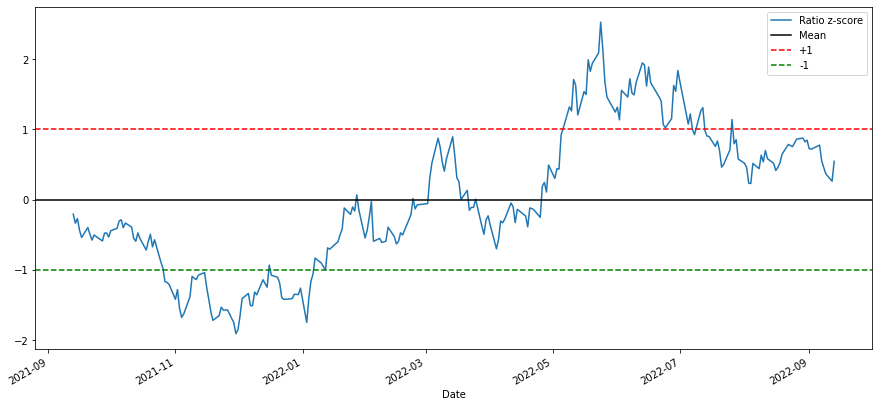

In [10]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

### Simple Strategy:
* Go "Long" the ratio whenever the z-score is below -1.0
* Go "Short" the ratio when the z-score is above 1.0
* Exit positions when the z-score approaches zero

This is a very simplistic example,in practice you would want to compute a more optimal weighting for how many shares to hold for S1 and S2, you would also want to trade using constantly updating statistics. 

In [11]:
ratios = data['XLI'] / data['XLY']
print(len(ratios))
train = ratios[:176]
test = ratios[176:]

253


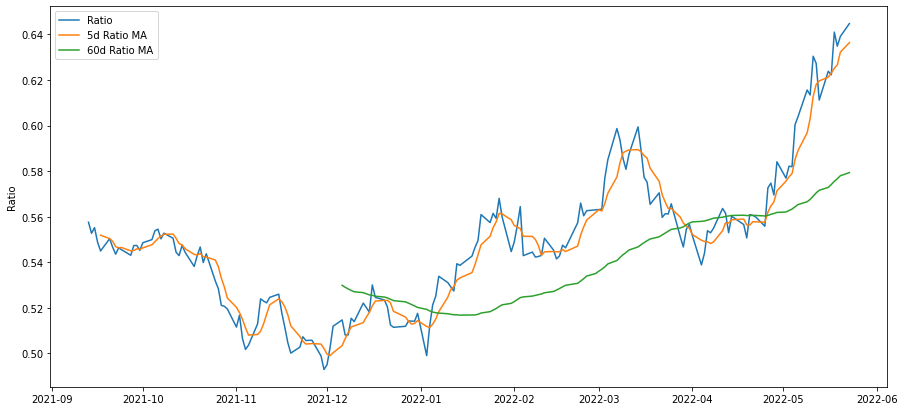

In [12]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

We can use the moving averages to compute the z-score of the ratio at each given time. This will tell us how extreme the ratio is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.


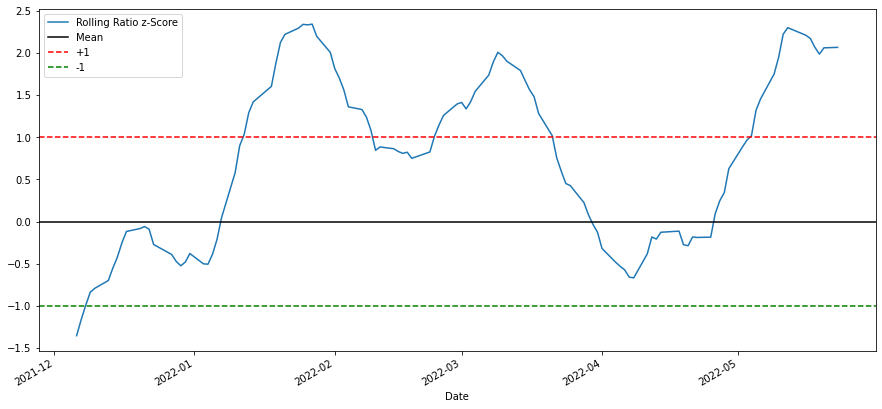

In [13]:
# Take a rolling 60 day standard deviation
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like.


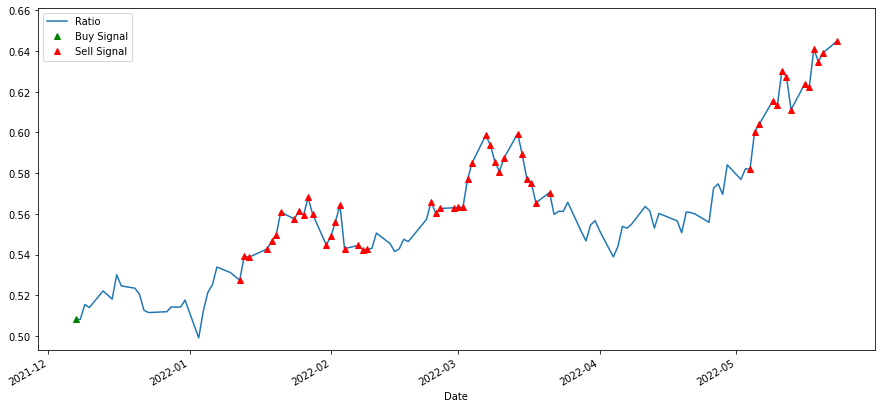

In [14]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

What does that mean for actual stocks that we are trading? Let’s take a look

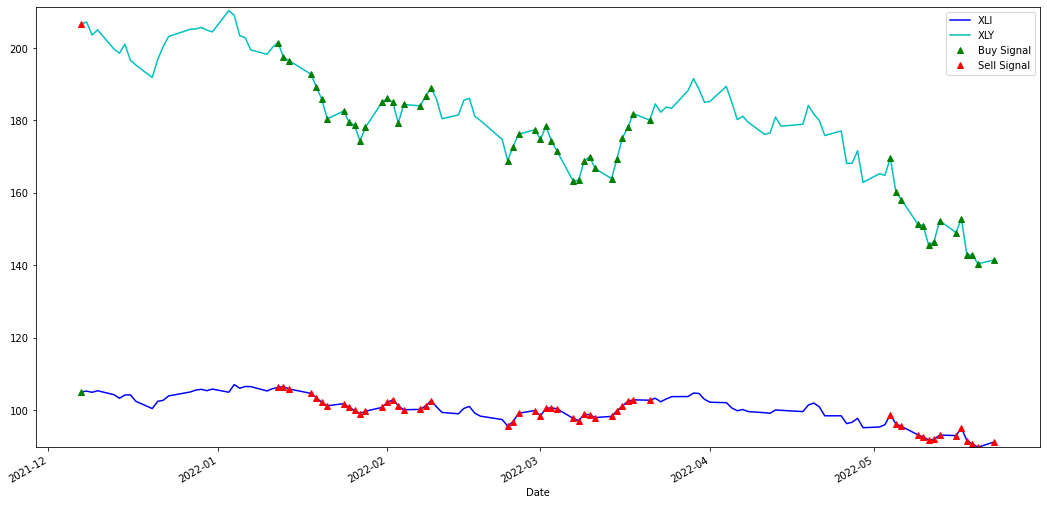

In [15]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = data['XLI'].iloc[:176]
S2 = data['XLY'].iloc[:176]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['XLI','XLY', 'Buy Signal', 'Sell Signal'])
plt.show()


Notice how we sometimes make money on the short leg and sometimes on the long leg, and sometimes both.

Let’s see what kind of profits this signal can generate. We write a simple backtester which buys 1 ratio when ratio is low, sell 1 ratio when it’s high and calculate PnL of these trades.

In [16]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money


trade(data['XLI'].iloc[:176], data['XLY'].iloc[:176], 5, 30)


125.45208233647529

The strategy seems profitable! Now we can optimize further by changing our moving average windows, by changing the thresholds for buy/sell and exit positions etc and check for performance improvements on validation data.
We could also try more sophisticated models like Logistic Regression, SVM etc to make our 1/-1 predictions.

Let's see how it does on test data

In [17]:
trade(data['XLI'].iloc[176:], data['XLY'].iloc[176:], 5, 30)

9.559268989057585


### Avoid Overfitting

Overfitting is the most dangerous pitfall of a trading strategy. In our model, we used rolling parameter estimates and may wish to optimize window length. We can simply iterate over all possible, reasonable window lengths and pick the length based on which our model performs the best . Below we write a simple loop to score window lengths based on pnl of training data and find the best one.

In [18]:
# Find the window length 0-254 
# that gives the highest returns using this strategy
length_scores = [trade(data['XLI'].iloc[:100], 
                data['XLY'].iloc[:100], 5, l) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 48


Now we check the performance of our model on test data and we find that this window length is far from optimal! This is because our original choice was clearly overfitted to the sample data.

In [19]:
# Find the returns for test data
# using what we think is the best window length
length_scores2 = [trade(data['XLI'].iloc[100:], 
                  data['XLY'].iloc[100:],5, l) 
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

48 day window: 70.04288159243316
69 day window: 137.73151091510005


We can see this if we also plot Pnl by window length separately for traning and test data

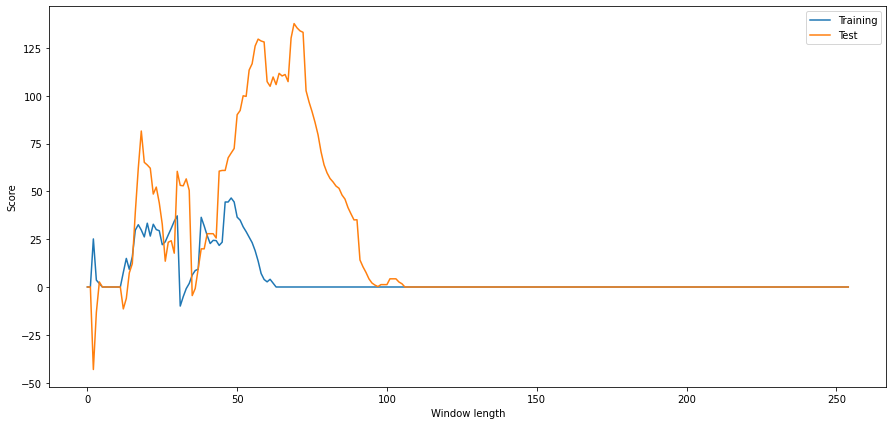

In [20]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()